In [3]:
# 基本库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 机器学习模块
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# 集成方法
from xgboost import XGBClassifier
import lightgbm as lgb
import catboost as cb

# 数据预处理
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder


In [4]:
import pandas as pd
data = pd.read_csv('train.csv')
data.head()

,user_id,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1374,58,No,Travel_Rarely,605,Sales,21,3,Life Sciences,1,...,3,80,1,29,2,2,1,0,0,0
1,1092,45,No,Travel_Rarely,950,Research & Development,28,3,Technical Degree,1,...,4,80,1,8,3,3,5,4,0,3
2,768,40,No,Travel_Rarely,300,Sales,26,3,Marketing,1,...,2,80,1,8,3,2,7,7,7,5
3,569,36,No,Non-Travel,1434,Sales,8,4,Life Sciences,1,...,2,80,0,10,1,3,10,7,0,9
4,911,25,Yes,Travel_Frequently,599,Sales,24,1,Life Sciences,1,...,4,80,0,1,4,3,1,0,1,0


In [5]:
data = data.drop(columns=['user_id'])
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,58,No,Travel_Rarely,605,Sales,21,3,Life Sciences,1,1938,...,3,80,1,29,2,2,1,0,0,0
1,45,No,Travel_Rarely,950,Research & Development,28,3,Technical Degree,1,1546,...,4,80,1,8,3,3,5,4,0,3
2,40,No,Travel_Rarely,300,Sales,26,3,Marketing,1,1066,...,2,80,1,8,3,2,7,7,7,5
3,36,No,Non-Travel,1434,Sales,8,4,Life Sciences,1,789,...,2,80,0,10,1,3,10,7,0,9
4,25,Yes,Travel_Frequently,599,Sales,24,1,Life Sciences,1,1273,...,4,80,0,1,4,3,1,0,1,0


In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder # preprocessing预处理模块 - 用于特征标准化、独热编码和数值编码
from sklearn.model_selection import train_test_split # model_selection 模型选择 - 用于将数据集划分为训练集和测试集


# 分离特征数据和标签数据
X = data.drop(['Attrition'], axis=1)  # 特征数据 除了标签以外的列读到x里面
y = data['Attrition'].map({'Yes': 1, 'No': 0})

In [7]:
X = X.drop(['StandardHours','EmployeeCount','Over18','EmployeeNumber','PerformanceRating'], axis=1)
# StandardHours
# EmployeeCount

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

def process_data(X):
    # 分离连续特征和离散特征
    continuous_features = X.select_dtypes(include=['float64', 'int64']).columns  # 连续
    print(continuous_features)

    # 保存原始索引
    original_index = X.index

    # 连续特征标准化
    scaler = StandardScaler()
    X_continuous = scaler.fit_transform(X[continuous_features])
    X_continuous_df = pd.DataFrame(X_continuous, columns=continuous_features, index=original_index)

    hot = ['BusinessTravel', 'Department', 'EducationField', 'MaritalStatus']
    lab = ['Gender', 'EnvironmentSatisfaction', 'JobSatisfaction', 'OverTime']

    # 无序离散特征独热编码
    onehot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')  # Handle potential new categories in test data
    X_hot = onehot_encoder.fit_transform(X[hot])
    X_hot_df = pd.DataFrame(X_hot.toarray(), columns=onehot_encoder.get_feature_names_out(hot), index=original_index)

    # 有序离散特征或二元分类特征标签编码
    # X_lab_df = X[lab].apply(lambda col: label_encoder.fit_transform(col)) # This is much better!
    X_lab_df = pd.DataFrame(index=original_index)
    for col in lab:
        if col in X.columns:  # Check if column exists
            le = LabelEncoder()
            X_lab_df[col] = le.fit_transform(X[col])

    # 删除原始数据中的标签编码列和独热编码列，避免列名重复
    X = X.drop(columns=lab, errors='ignore')  # Use errors='ignore' to handle cases where columns don't exist
    X = X.drop(columns=hot, errors='ignore')

    # 拼接处理后的特征
    X = pd.concat([X_continuous_df, X_hot_df, X_lab_df], axis=1)

    # 检查并删除重复列
    X = X.loc[:,~X.columns.duplicated()].copy() # .copy() is very important, avoid SettingWithCopyWarning

    return X

# 示例用法 (假设 X 是你的 DataFrame)
# 创建一个示例 DataFrame (为了演示,你需要有自己的数据)

# X = pd.DataFrame(data)

X = process_data(X.copy()) # always work on copies of your data
# print(X_processed)

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')


最优特征数量: 27
被选中的特征索引:  [ True False  True False  True False  True  True  True  True False  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True False  True False  True  True False  True  True  True  True]


c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21449 (\N{CJK UNIFIED IDEOGRAPH-53C9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  

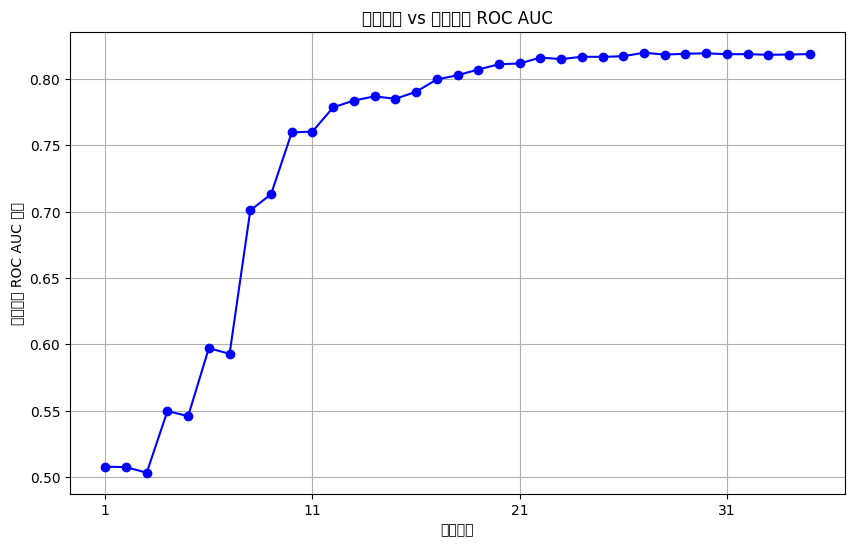

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold

# 生成示例数据集（假设有 100 个样本和 32 个特征）
# X, y = make_classification(n_samples=100, n_features=32, n_informative=15, n_redundant=5, random_state=42)

# 定义基础模型（以随机森林为例）
model = SVC(kernel='linear', probability=True, random_state=42)

# 定义交叉验证策略（5 折交叉验证）
cv = StratifiedKFold(n_splits=5)

# 定义 RFECV
rfecv = RFECV(
    estimator=model,  # 基础模型
    step=1,  # 每次迭代删除 1 个特征
    cv=cv,  # 交叉验证策略
    scoring='roc_auc',  # 使用 ROC AUC 作为评估标准
    min_features_to_select=1  # 至少选择 1 个特征
)

# 训练 RFECV 模型
rfecv.fit(X, y)

# 输出最优特征数量
print(f"最优特征数量: {rfecv.n_features_}")

# 输出被选中的特征
selected_features = rfecv.support_
print("被选中的特征索引: ", selected_features)

# 绘制特征数量与交叉验证分数的曲线图
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o', linestyle='-', color='b')
plt.title("特征数量 vs 交叉验证 ROC AUC")
plt.xlabel("特征数量")
plt.ylabel("交叉验证 ROC AUC 分数")
plt.grid(True)
plt.xticks(range(1, len(rfecv.cv_results_['mean_test_score']) + 1,10))
plt.show()

In [10]:
selected_features = rfecv.support_
print("被选中的特征索引: ", selected_features)
X= X.loc[:, selected_features]
# print("筛选后的特征数据集: ")

被选中的特征索引:  [ True False  True False  True False  True  True  True  True False  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True False  True False  True  True False  True  True  True  True]


In [11]:

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# 对训练集进行过采样

from imblearn.over_sampling import SMOTE

# 使用 SMOTE 进行过采样,并赋值给自己
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\UserFiles\Anaconda3\envs\hh\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\UserFiles\Anaconda3\envs\hh\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\UserFiles\Anaconda3\envs\hh\lib\subprocess.py", line 1327, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


In [13]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, f1_score,roc_curve,auc
# 创建逻辑回归模型
logreg = LogisticRegression(penalty='l2',C=3,random_state=23)
# logreg = LogisticRegression(penalty='l1',C=124.15503013717493,solver='liblinear',class_weight='balanced')

# 训练模型
logreg.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = logreg.predict(X_test)

# 评估模型
accuracy = accuracy_score(y_test, y_pred)
print(f"模型准确率: {accuracy}")

# 打印分类报告
print("分类报告:")
print(classification_report(y_test, y_pred))

# 计算 F1 值
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 值: {f1}")

y_pred_proba = logreg.predict_proba(X_test)[:, 1]
print(f"auc:{roc_auc_score(y_test, y_pred_proba)}")

模型准确率: 0.7330508474576272
分类报告:
              precision    recall  f1-score   support

           0       0.90      0.74      0.82       187
           1       0.41      0.69      0.52        49

    accuracy                           0.73       236
   macro avg       0.66      0.72      0.67       236
weighted avg       0.80      0.73      0.75       236

F1 值: 0.7537573195213669
auc:0.8033395176252319


In [46]:
# 基本库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 机器学习模块
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
# 集成方法
from xgboost import XGBClassifier
import lightgbm as lgb
import catboost as cb

### 逻辑回归

Fitting 10 folds for each of 30 candidates, totalling 300 fits


c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
50 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\sklearn\linear_model\_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver,

最佳模型参数: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
最佳模型在测试集上的准确率: 0.7457627118644068
最佳模型分类报告:
              precision    recall  f1-score   support

           0       0.90      0.76      0.83       187
           1       0.43      0.69      0.53        49

    accuracy                           0.75       236
   macro avg       0.67      0.73      0.68       236
weighted avg       0.81      0.75      0.76       236

最佳模型 F1 值: 0.7644702158060701
最佳模型 AUC: 0.8225472006984612

最佳模型混淆矩阵:
 [[142  45]
 [ 15  34]]


c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35843 (\N{CJK UNIFIED IDEOGRAPH-8C03}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21442 (\N{CJK UNIFIED IDEOGRAPH-53C2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36923 (\N{CJK UNIFIED IDEOGRAPH-903B}) missing from current font.
  

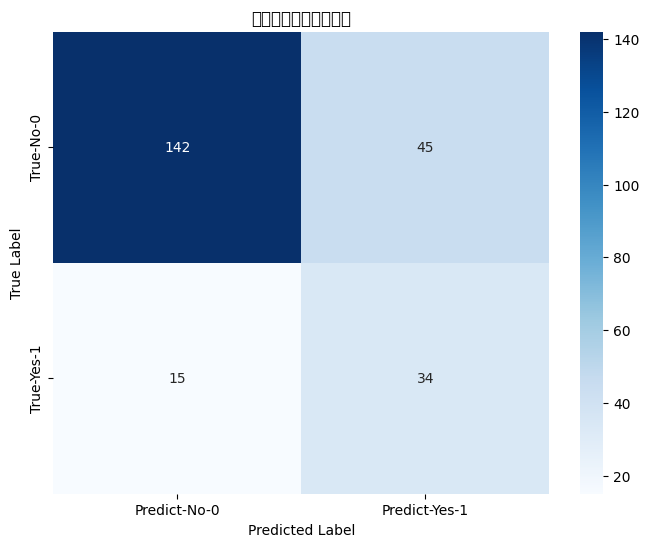

In [68]:
# 定义参数网格
param_grid = {
    'penalty': ['l1', 'l2', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

# 创建 GridSearchCV 对象
grid_search = GridSearchCV(estimator=LogisticRegression(random_state=43),
                           param_grid=param_grid,
                           cv=10,
                           scoring='recall',
                           verbose=2,
                           n_jobs=-1)

# 在训练数据上运行 GridSearchCV
grid_search.fit(X_train, y_train)

# 获取最佳模型和最佳参数
best_logreg = grid_search.best_estimator_
best_params = grid_search.best_params_

print("最佳模型参数:", best_params)

# 使用最佳模型在测试集上进行预测
y_pred_best = best_logreg.predict(X_test)

# 评估最佳模型
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"最佳模型在测试集上的准确率: {accuracy_best}")

print("最佳模型分类报告:")
print(classification_report(y_test, y_pred_best))

f1_best = f1_score(y_test, y_pred_best, average='weighted')
print(f"最佳模型 F1 值: {f1_best}")

y_pred_proba_best = best_logreg.predict_proba(X_test)[:, 1]
print(f"最佳模型 AUC: {roc_auc_score(y_test, y_pred_proba_best)}")

cm = confusion_matrix(y_test, y_pred_best)
print("\n最佳模型混淆矩阵:\n", cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predict-No-0', 'Predict-Yes-1'],
            yticklabels=['True-No-0', 'True-Yes-1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('调参后的逻辑回归模型')
plt.show()

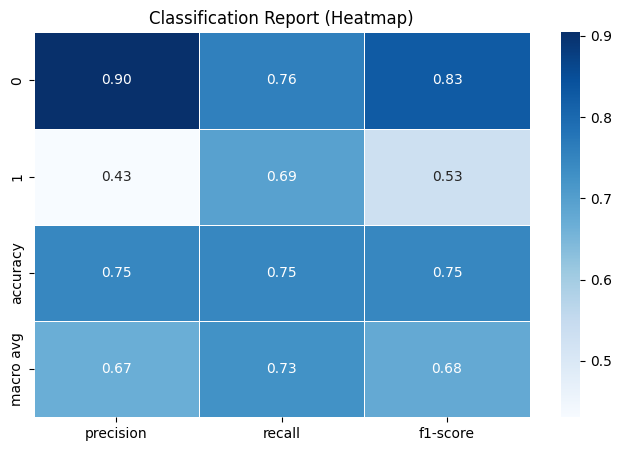

In [69]:
# 计算分类报告
report = classification_report(y_test, y_pred_best, output_dict=True)  # 转换为字典格式

# 转换为 DataFrame
df_report = pd.DataFrame(report).T

# 只保留 precision、recall、f1-score
df_report = df_report.iloc[:-1, :3]  # 去掉 'support' 列

# 绘制热力图
plt.figure(figsize=(8, 5))
sns.heatmap(df_report, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Classification Report (Heatmap)")
plt.show()

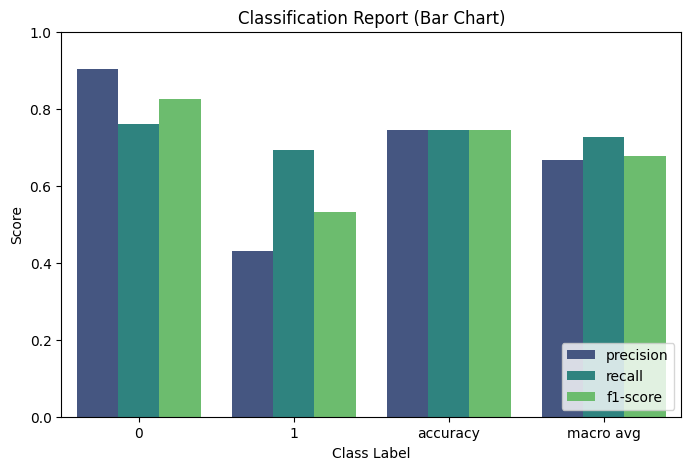

In [70]:
# 重新整理数据
df_melted = df_report.reset_index().melt(id_vars="index", var_name="Metric", value_name="Score")

# 绘制分组柱状图
plt.figure(figsize=(8, 5))
sns.barplot(x="index", y="Score", hue="Metric", data=df_melted, palette="viridis")
plt.ylim(0, 1)  # 归一化
plt.xlabel("Class Label")
plt.ylabel("Score")
plt.title("Classification Report (Bar Chart)")
plt.legend(loc="lower right")
plt.show()


GDBC

默认参数 GBDT 模型在测试集上的准确率: 0.8559
默认参数 GBDT 模型分类报告:
              precision    recall  f1-score   support

           0       0.87      0.97      0.91       187
           1       0.78      0.43      0.55        49

    accuracy                           0.86       236
   macro avg       0.82      0.70      0.73       236
weighted avg       0.85      0.86      0.84       236

默认参数 GBDT 模型 F1 值: 0.8391
默认参数 GBDT 模型 AUC: 0.8028

默认参数 GBDT 模型混淆矩阵:
 [[181   6]
 [ 28  21]]


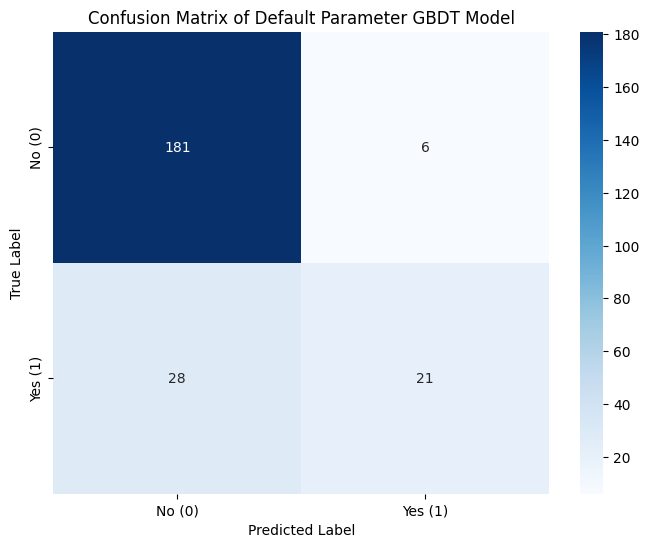

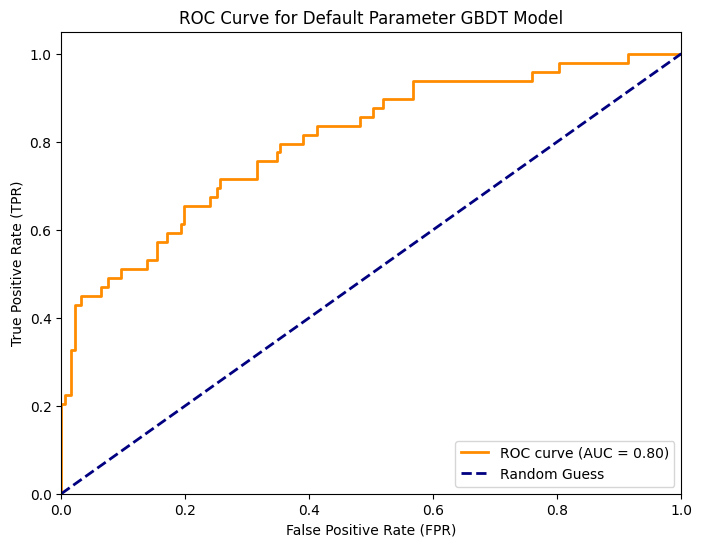

In [112]:
# 创建 GradientBoostingClassifier 模型，使用默认参数
gbdt_default = GradientBoostingClassifier(random_state=42) # 可以设置 random_state 以保证结果可复现

# 在训练数据上训练模型
gbdt_default.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_gbdt_default = gbdt_default.predict(X_test)
y_pred_proba_gbdt_default = gbdt_default.predict_proba(X_test)[:, 1]

# 评估默认参数 GBDT 模型
accuracy_gbdt_default = accuracy_score(y_test, y_pred_gbdt_default)
print(f"默认参数 GBDT 模型在测试集上的准确率: {accuracy_gbdt_default:.4f}")

print("默认参数 GBDT 模型分类报告:")
print(classification_report(y_test, y_pred_gbdt_default))

f1_gbdt_default = f1_score(y_test, y_pred_gbdt_default, average='weighted')
print(f"默认参数 GBDT 模型 F1 值: {f1_gbdt_default:.4f}")

auc_gbdt_default = roc_auc_score(y_test, y_pred_proba_gbdt_default)
print(f"默认参数 GBDT 模型 AUC: {auc_gbdt_default:.4f}")

# 计算混淆矩阵 - 针对默认参数 GBDT 模型
cm_gbdt_default = confusion_matrix(y_test, y_pred_gbdt_default)
print("\n默认参数 GBDT 模型混淆矩阵:\n", cm_gbdt_default)

# 可视化混淆矩阵 - 针对默认参数 GBDT 模型
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gbdt_default, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No (0)', 'Yes (1)'],
            yticklabels=['No (0)', 'Yes (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Default Parameter GBDT Model')
plt.show()

# 计算 ROC 曲线和 AUC (同样针对默认参数 GBDT 模型)
fpr_gbdt_default, tpr_gbdt_default, thresholds_gbdt_default = roc_curve(y_test, y_pred_proba_gbdt_default)
roc_auc_gbdt_default = auc(fpr_gbdt_default, tpr_gbdt_default)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr_gbdt_default, tpr_gbdt_default, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_gbdt_default:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Default Parameter GBDT Model')
plt.legend(loc="lower right")
plt.show()

### 模型融合

Stacking AUC: 0.8182
F1 Score (based on probabilities): 0.8296

最佳 GBDT 模型混淆矩阵:
 [[180   7]
 [ 29  20]]


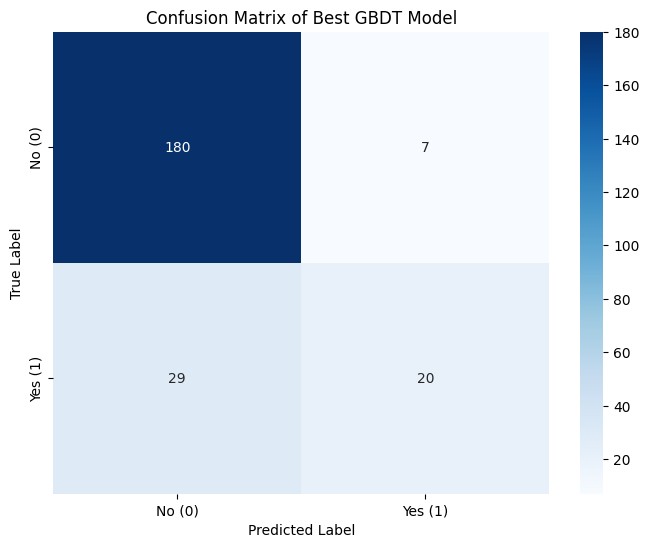

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91       187
           1       0.74      0.41      0.53        49

    accuracy                           0.85       236
   macro avg       0.80      0.69      0.72       236
weighted avg       0.84      0.85      0.83       236


Accuracy (Optimal Threshold for F1): 0.8475


In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import lightgbm as lgb
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import catboost as cb

# 假设 X_train, X_test, y_train, y_test 是你已经准备好的训练和测试数据

# lr{'C': 124.15503013717493, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced'}
# svc{'C': 70.20314474657421, 'kernel': 'rbf', 'gamma': 0.06730170359351065, 'class_weight': None}.
# rf{'n_estimators': 237, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'class_weight': None}
#   ('logreg', LogisticRegression(C=0.05696421076895237, solver='lbfgs',class_weight='balanced')),
# xgb {'n_estimators': 628, 'learning_rate': 0.13417725668296787, 'max_depth': 5, 'subsample': 0.6374058908219749, 'colsample_bytree': 0.7653292476281399, 'gamma': 0.4094987931949272, 'reg_alpha': 4.855727115959089, 'reg_lambda': 0.5360691022682742}
#     ('xgboost', XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=3,
#                     n_estimators=100, subsample=0.8)),
#     ('lightgbm', lgb.LGBMClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=5,
#                                     n_estimators=100, num_leaves=31, subsample=0.8)),
#     # ('catboost', cb.CatBoostClassifier(verbose=0, iterations=395, depth=7, 
#     #                                     learning_rate=0.3156251048306349, l2_leaf_reg=10.938235283132196, 
#     #                                     border_count=73)),
#     ('svm',SVC(C=10, probability=True))

    # ('logreg', LogisticRegression(C=124.15503013717493, solver='liblinear',class_weight='balanced',penalty='l1')),
    # ('xgboost', XGBClassifier(colsample_bytree=0.7653292476281399, learning_rate=0.13417725668296787, max_depth=5,
    #                 n_estimators=628, subsample= 0.6374058908219749,gamma=0.4094987931949272,reg_alpha=4.855727115959089,reg_lambda=0.5360691022682742)),
    # ('lightgbm', RandomForestClassifier(min_samples_leaf=3, n_estimators=237,max_depth=5, min_samples_split=2)),
    # # ('catboost', cb.CatBoostClassifier(verbose=0, iterations=395, depth=7, 
    # #                                     learning_rate=0.3156251048306349, l2_leaf_reg=10.938235283132196, 
    # #                                     border_count=73)),
    # ('svm',SVC(C=70.20314474657421, probability=True,kernel='rbf',gamma=0.06730170359351065))
# 定义基础学习器（模型）

base_learners = [

    ('rf', RandomForestClassifier(n_estimators=90,max_depth=8,min_samples_leaf=6,random_state=42)),
    ('gbdt', GradientBoostingClassifier(learning_rate=0.25, max_depth=2, 
                subsample=1, max_features='sqrt',random_state=42)),
    ('svm',SVC(C=1, gamma=0.01,random_state=42))
]

# 定义元学习器（第二层分类器）
meta_learner = LogisticRegression(random_state=42)

# 定义StackingClassifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# 训练Stacking模型
stacking_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_stacking = stacking_model.predict_proba(X_test)[:, 1]

# 计算AUC分数
stacking_auc = roc_auc_score(y_test, y_pred_stacking)
print(f"Stacking AUC: {stacking_auc:.4f}")
# 原本的数据可以跑0.8631 现在只能跑0.8239
# 获取预测的概率值
y_pred_proba = stacking_model.predict_proba(X_test)[:, 1]

# 使用0.5的阈值将概率值转换为标签（0或1）
y_pred = (y_pred_proba > 0.5).astype(int)

# 计算F1值
f1 = f1_score(y_test, y_pred,average='weighted')
print(f"F1 Score (based on probabilities): {f1:.4f}")


y_pred_p = stacking_model.predict(X_test)
# 计算混淆矩阵 - 针对最佳 GBDT 模型
cm_gbdt = confusion_matrix(y_test, y_pred_p)
print("\n最佳 GBDT 模型混淆矩阵:\n", cm_gbdt)

# 可视化混淆矩阵 - 针对最佳 GBDT 模型
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gbdt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No (0)', 'Yes (1)'],
            yticklabels=['No (0)', 'Yes (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Best GBDT Model')
plt.show()

# 输出分类报告
print("Classification Report:\n", classification_report(y_test, y_pred))
# 最佳阈值: 0.29999999999999993
# 最大F1值: 0.8756673299938244

# 计算并输出准确率
accuracy_optimal_f1 = accuracy_score(y_test, y_pred) # 计算准确率
print(f"\nAccuracy (Optimal Threshold for F1): {accuracy_optimal_f1:.4f}") # 输出准确率，并格式化


In [80]:
base_learners = [
# {'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}
    ('rf', RandomForestClassifier(n_estimators=90,max_depth=8,min_samples_leaf=6)),
    ('gbdc', GradientBoostingClassifier(learning_rate=0.137, max_depth=3, 
                subsample=0.8, max_features='log2')),
                
    ('lr',LogisticRegression(C=10, penalty= 'l1',solver='liblinear'))
]

# 定义元学习器（第二层分类器）
meta_learner = SVC(C=1, gamma=0.01,probability=True)

# 定义StackingClassifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# 训练Stacking模型
stacking_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_stacking = stacking_model.predict_proba(X_test)[:, 1]

# 计算AUC分数
stacking_auc = roc_auc_score(y_test, y_pred_stacking)
print(f"Stacking AUC: {stacking_auc:.4f}")

Stacking AUC: 0.8232


In [81]:
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 目标函数：Optuna 会自动优化 AUC
def objective(trial):
    # 采样参数
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 200)
    rf_max_depth = trial.suggest_int("rf_max_depth", 5, 15)

    gbdt_learning_rate = trial.suggest_float("gbdt_learning_rate", 0.01, 0.2)
    gbdt_max_depth = trial.suggest_int("gbdt_max_depth", 3, 6)

    lr_C = trial.suggest_float("lr_C", 0.1, 10.0)
    
    svm_C = trial.suggest_float("svm_C", 0.1, 10.0)
    svm_gamma = trial.suggest_float("svm_gamma", 0.001, 0.1)

    # 定义 Stacking 模型
    base_learners = [
        ('rf', RandomForestClassifier(n_estimators=rf_n_estimators, max_depth=rf_max_depth)),
        ('gbdc', GradientBoostingClassifier(learning_rate=gbdt_learning_rate, max_depth=gbdt_max_depth)),
        ('lr', LogisticRegression(C=lr_C, penalty='l1', solver='liblinear'))
    ]
    meta_learner = SVC(C=svm_C, gamma=svm_gamma, probability=True)

    model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)
    model.fit(X_train, y_train)

    # 计算 AUC
    y_pred_stacking = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_stacking)

    return auc_score  # Optuna 会自动优化这个分数

# 运行 Optuna 进行搜索
study = optuna.create_study(direction="maximize")  # 目标是最大化 AUC
study.optimize(objective, n_trials=50)  # 进行 50 次搜索

# 输出最佳参数
print("最佳参数: ", study.best_params)

# 训练最优模型
best_params = study.best_params
final_learners = [
    ('rf', RandomForestClassifier(n_estimators=best_params["rf_n_estimators"], max_depth=best_params["rf_max_depth"])),
    ('gbdc', GradientBoostingClassifier(learning_rate=best_params["gbdt_learning_rate"], max_depth=best_params["gbdt_max_depth"])),
    ('lr', LogisticRegression(C=best_params["lr_C"], penalty='l1', solver='liblinear'))
]
meta_learner_final = SVC(C=best_params["svm_C"], gamma=best_params["svm_gamma"], probability=True)

best_model = StackingClassifier(estimators=final_learners, final_estimator=meta_learner_final)
best_model.fit(X_train, y_train)

# 计算最终 AUC
y_pred_stacking = best_model.predict_proba(X_test)[:, 1]
stacking_auc = roc_auc_score(y_test, y_pred_stacking)
print(f"最终 Stacking AUC: {stacking_auc:.4f}")


c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-23 21:57:36,940] A new study created in memory with name: no-name-c0bb1035-6c67-4f50-ada8-edcecdfb4f37
[I 2025-03-23 21:57:48,353] Trial 0 finished with value: 0.772890974571647 and parameters: {'rf_n_estimators': 174, 'rf_max_depth': 5, 'gbdt_learning_rate': 0.14610265099720596, 'gbdt_max_depth': 6, 'lr_C': 7.789087288393219, 'svm_C': 5.645543768476108, 'svm_gamma': 0.04380395046708124}. Best is trial 0 with value: 0.772890974571647.
[I 2025-03-23 21:57:55,313] Trial 1 finished with value: 0.7794390483466115 and parameters: {'rf_n_estimators': 176, 'rf_max_depth': 5, 'gbdt_learning_rate': 0.08432132694536291, 'gbdt_max_depth': 3, 'lr_C': 8.152901865271797, 'svm_C': 9.518608591237887, 'svm_gamma': 0.06825816002309226}. Best i

最佳参数:  {'rf_n_estimators': 96, 'rf_max_depth': 15, 'gbdt_learning_rate': 0.15541171831818662, 'gbdt_max_depth': 4, 'lr_C': 2.6670632672597177, 'svm_C': 2.443664863050343, 'svm_gamma': 0.0019202402167045997}
最终 Stacking AUC: 0.8009


In [ ]:
base_learners = [
# {'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}
    ('rf', RandomForestClassifier(n_estimators=90,max_depth=8,min_samples_leaf=6,random_state=45)),
    ('gbdt', GradientBoostingClassifier(learning_rate=0.25, max_depth=2, random_state=45,
                subsample=1, max_features='sqrt')),
    ('lr',LogisticRegression(C=10, penalty= 'l1', solver= 'liblinear'))
]

# 定义元学习器（第二层分类器）
meta_learner = SVC(C=10, gamma=0.01,kernel='rbf',random_state=45,probability=True)

# 定义StackingClassifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# 训练Stacking模型
stacking_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_stacking = stacking_model.predict_proba(X_test)[:, 1]

# 计算AUC分数
stacking_auc = roc_auc_score(y_test, y_pred_stacking)
print(f"Stacking AUC: {stacking_auc:.4f}")

Stacking AUC: 0.8251


In [85]:
base_learners = [
# {'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}
    ('rf', RandomForestClassifier(n_estimators=90,max_depth=8,min_samples_leaf=6,random_state=45)),
    ('gbdt', GradientBoostingClassifier(learning_rate=0.25, max_depth=2, random_state=45,
                subsample=1, max_features='sqrt')),
    ('lr',LogisticRegression(C=10, penalty= 'l1', solver= 'liblinear')),
    ('svm', SVC(C=10, gamma=0.01,kernel='rbf',random_state=45))
]

# 定义元学习器（第二层分类器）
meta_learner =GradientBoostingClassifier(learning_rate=0.25, max_depth=2, random_state=45,
                subsample=1, max_features='sqrt')

# 定义StackingClassifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# 训练Stacking模型
stacking_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_stacking = stacking_model.predict_proba(X_test)[:, 1]

# 计算AUC分数
stacking_auc = roc_auc_score(y_test, y_pred_stacking)
print(f"Stacking AUC: {stacking_auc:.4f}")

Stacking AUC: 0.7641


In [23]:
base_learners = [
# {'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}
    ('rf', RandomForestClassifier(n_estimators=90,max_depth=8,min_samples_leaf=6,random_state=45)),
    ('gbdt', GradientBoostingClassifier(learning_rate=0.25, max_depth=2, random_state=45,
                subsample=1, max_features='sqrt')),
    ('lr',LogisticRegression(C=10, penalty= 'l1', solver= 'liblinear')),
    ('svm', SVC(C=10, gamma=0.01,kernel='rbf',random_state=45))
]

# 定义元学习器（第二层分类器）
meta_learner =LogisticRegression(C=10, penalty= 'l1', solver= 'liblinear')

# 定义StackingClassifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# 训练Stacking模型
stacking_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_stacking = stacking_model.predict_proba(X_test)[:, 1]

# 计算AUC分数
stacking_auc = roc_auc_score(y_test, y_pred_stacking)
print(f"Stacking AUC: {stacking_auc:.4f}")

Stacking AUC: 0.8223


In [22]:
base_learners = [
# {'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}
    ('rf', RandomForestClassifier(n_estimators=90,max_depth=8,min_samples_leaf=6,random_state=45)),
    ('gbdt', GradientBoostingClassifier(learning_rate=0.25, max_depth=2, random_state=45,
                subsample=1, max_features='sqrt')),
    ('lr',LogisticRegression(C=10, penalty= 'l1', solver= 'liblinear')),
    ('svm', SVC(C=10, gamma=0.01,kernel='rbf',random_state=45))
]

# 定义元学习器（第二层分类器）
meta_learner =RandomForestClassifier(n_estimators=90,max_depth=8,min_samples_leaf=6,random_state=45)

# 定义StackingClassifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# 训练Stacking模型
stacking_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_stacking = stacking_model.predict_proba(X_test)[:, 1]

# 计算AUC分数
stacking_auc = roc_auc_score(y_test, y_pred_stacking)
print(f"Stacking AUC: {stacking_auc:.4f}")

Stacking AUC: 0.7883


最佳阈值: 0.45999999999999985
最大F1值: 0.8561002446957647


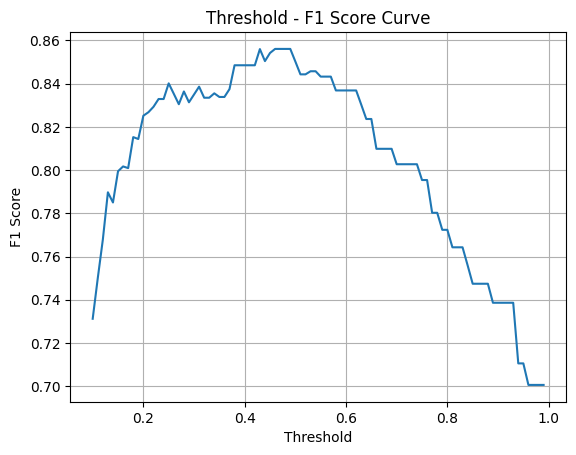

Confusion Matrix:
 [[184   3]
 [ 27  22]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       187
           1       0.88      0.45      0.59        49

    accuracy                           0.87       236
   macro avg       0.88      0.72      0.76       236
weighted avg       0.87      0.87      0.86       236


Accuracy (Optimal Threshold for F1): 0.8729

AUC: 0.8568


In [ ]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 初始化列表用于存储不同阈值下的F1值
f1_scores = []
thresholds = np.arange(0.1, 1, 0.01)  # 从0.1到1 每次增加0.01

# 从不同的阈值计算F1值
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)  # 将概率转换为类别
    f1 = f1_score(y_test, y_pred,average='weighted')  # 计算F1值
    f1_scores.append(f1)  # 保存F1值

# 找到最大F1值及其对应的阈值
max_f1_index = np.argmax(f1_scores)  # 找到最大F1值的索引
optimal_threshold_f1 = thresholds[max_f1_index]  # 最佳阈值
max_f1 = f1_scores[max_f1_index]

print(f"最佳阈值: {optimal_threshold_f1}")
print(f"最大F1值: {max_f1}")

# 绘制阈值 - F1值曲线
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold - F1 Score Curve')
plt.grid(True)
plt.show()



# 输出混淆矩阵
y_pred_optimal_f1 = (y_pred_proba >= optimal_threshold_f1).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_optimal_f1))

# 输出分类报告
print("Classification Report:\n", classification_report(y_test, y_pred_optimal_f1))
# 最佳阈值: 0.29999999999999993
# 最大F1值: 0.8756673299938244

# 计算并输出准确率
accuracy_optimal_f1 = accuracy_score(y_test, y_pred_optimal_f1) # 计算准确率
print(f"\nAccuracy (Optimal Threshold for F1): {accuracy_optimal_f1:.4f}") # 输出准确率，并格式化



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 641, number of negative: 640
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 1281, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500390 -> initscore=0.001561
[LightGBM] [Info] Start training from score 0.001561
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 640, number of negative: 641
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3674
[LightGBM] [Info] Number of data points in the train set: 1281, number of used features: 2

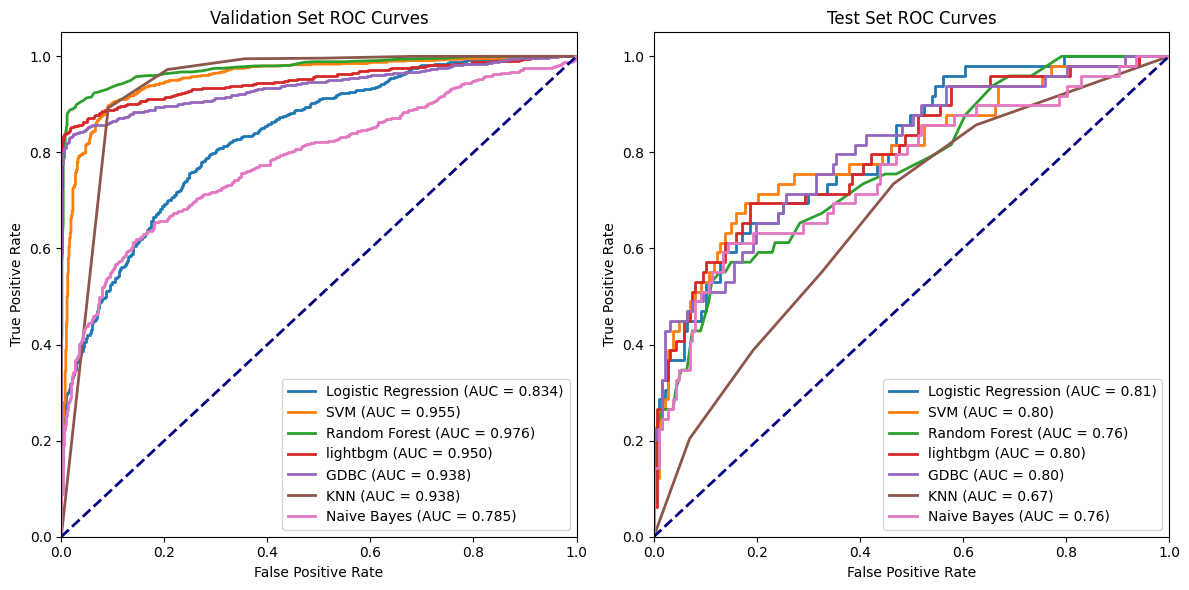

In [115]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import auc
from sklearn.neighbors import KNeighborsClassifier
# 假设你已经有了数据集 X_train, X_test, y_train, y_test

        # max_depth=10, max_features='sqrt', min_samples_leaf=1,
        # min_samples_split=10, n_estimators=200
# 定义模型及其最佳参数
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "SVM": SVC(probability=True,random_state=42),
    
    "Random Forest": RandomForestClassifier(random_state=42
    ),"lightbgm":lgb.LGBMClassifier(),
    "GDBC": GradientBoostingClassifier(random_state=42),
    "KNN":KNeighborsClassifier(), # KNN
    "Naive Bayes": GaussianNB(),
}

# 绘制验证集的 ROC 曲线
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 左边图：验证集

for name, model in models.items():
    # 使用交叉验证获取验证集的预测概率
    y_pred_val = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba')[:, 1]
    fpr, tpr, _ = roc_curve(y_train, y_pred_val)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Set ROC Curves')
plt.legend(loc="lower right")

# 绘制测试集的 ROC 曲线
plt.subplot(1, 2, 2)  # 右边图：测试集

for name, model in models.items():
    # 训练模型并在测试集上进行预测
    model.fit(X_train, y_train)
    y_pred_test = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_test)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curves')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

## 效果较好

In [91]:
base_learners = [
# {'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}
    ('rf', RandomForestClassifier(n_estimators=90,max_depth=8,min_samples_leaf=6,random_state=45)),
    ('gbdt', GradientBoostingClassifier(learning_rate=0.25, max_depth=2, random_state=45,
                subsample=1, max_features='sqrt')),
    ('svm',SVC(C=10, gamma=0.01,random_state=45,probability=True))
]

# 定义元学习器（第二层分类器）
meta_learner = LogisticRegression(C=3, penalty= 'l2', solver= 'sag')

# 定义StackingClassifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# 训练Stacking模型
stacking_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_stacking = stacking_model.predict_proba(X_test)[:, 1]

# 计算AUC分数
stacking_auc = roc_auc_score(y_test, y_pred_stacking)
print(f"Stacking AUC: {stacking_auc:.4f}")

Stacking AUC: 0.8328


In [92]:
# 获取预测的概率值
y_pred_proba = stacking_model.predict_proba(X_test)[:, 1]

# 使用0.5的阈值将概率值转换为标签（0或1）
y_pred = (y_pred_proba > 0.5).astype(int)

# 计算F1值
f1 = f1_score(y_test, y_pred,average='weighted')
print(f"F1 Score (based on probabilities): {f1:.4f}")

F1 Score (based on probabilities): 0.8430


最佳阈值: 0.3599999999999999
最大F1值: 0.8533272104867663


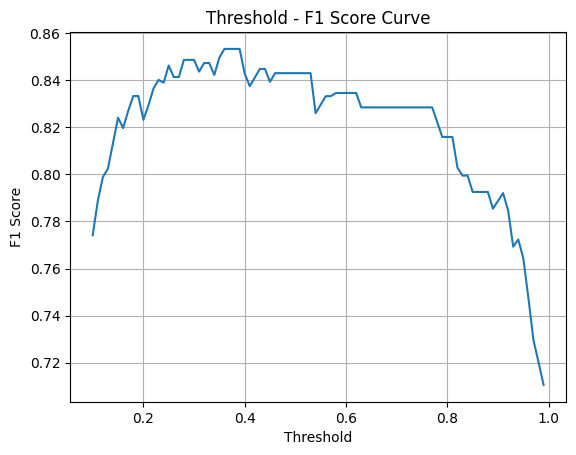

Confusion Matrix:
 [[176  11]
 [ 22  27]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91       187
           1       0.71      0.55      0.62        49

    accuracy                           0.86       236
   macro avg       0.80      0.75      0.77       236
weighted avg       0.85      0.86      0.85       236



In [93]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 初始化列表用于存储不同阈值下的F1值
f1_scores = []
thresholds = np.arange(0.1, 1, 0.01)  # 从0.1到1 每次增加0.01

# 从不同的阈值计算F1值
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)  # 将概率转换为类别
    f1 = f1_score(y_test, y_pred,average='weighted')  # 计算F1值
    f1_scores.append(f1)  # 保存F1值

# 找到最大F1值及其对应的阈值
max_f1_index = np.argmax(f1_scores)  # 找到最大F1值的索引
optimal_threshold_f1 = thresholds[max_f1_index]  # 最佳阈值
max_f1 = f1_scores[max_f1_index]

print(f"最佳阈值: {optimal_threshold_f1}")
print(f"最大F1值: {max_f1}")

# 绘制阈值 - F1值曲线
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold - F1 Score Curve')
plt.grid(True)
plt.show()

# 输出混淆矩阵
y_pred_optimal_f1 = (y_pred_proba >= optimal_threshold_f1).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_optimal_f1))

# 输出分类报告
print("Classification Report:\n", classification_report(y_test, y_pred_optimal_f1))
# 最佳阈值: 0.29999999999999993
# 最大F1值: 0.8756673299938244


### 加了lightgbm

In [27]:
base_learners = [
# {'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}
    ('rf', RandomForestClassifier(n_estimators=90,max_depth=8,min_samples_leaf=6,random_state=45)),
    ('gbdt', GradientBoostingClassifier(learning_rate=0.25, max_depth=2, random_state=45,
                subsample=1, max_features='sqrt')),
    ('svm',SVC(C=10, gamma=0.01,random_state=45,probability=True)),
    ('lightgbm', lgb.LGBMClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=5,
                                    n_estimators=100, num_leaves=31, subsample=0.8)),
    # ('catboost', cb.CatBoostClassifier(verbose=0, iterations=395, depth=7, 
    #                                     learning_rate=0.3156251048306349, l2_leaf_reg=10.938235283132196, 
    #                                     border_count=73)),
]

# 定义元学习器（第二层分类器）
meta_learner = LogisticRegression(C=0.05696421076895237, solver='lbfgs')

# 定义StackingClassifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# 训练Stacking模型
stacking_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_stacking = stacking_model.predict_proba(X_test)[:, 1]

# 计算AUC分数
stacking_auc = roc_auc_score(y_test, y_pred_stacking)
print(f"Stacking AUC: {stacking_auc:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 801, number of negative: 801
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4631
[LightGBM] [Info] Number of data points in the train set: 1602, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [28]:
# 获取预测的概率值
y_pred_proba = stacking_model.predict_proba(X_test)[:, 1]

# 使用0.5的阈值将概率值转换为标签（0或1）
y_pred = (y_pred_proba > 0.5).astype(int)

# 计算F1值
f1 = f1_score(y_test, y_pred,average='weighted')
print(f"F1 Score (based on probabilities): {f1:.4f}")

F1 Score (based on probabilities): 0.8523


最佳阈值: 0.3599999999999999
最大F1值: 0.8560759272757138


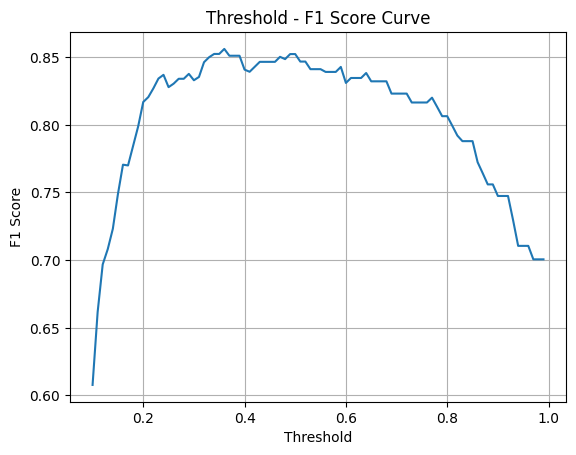

Confusion Matrix:
 [[174  13]
 [ 20  29]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91       187
           1       0.69      0.59      0.64        49

    accuracy                           0.86       236
   macro avg       0.79      0.76      0.78       236
weighted avg       0.85      0.86      0.86       236



In [107]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 初始化列表用于存储不同阈值下的F1值
f1_scores = []
thresholds = np.arange(0.1, 1, 0.01)  # 从0.1到1 每次增加0.01

# 从不同的阈值计算F1值
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)  # 将概率转换为类别
    f1 = f1_score(y_test, y_pred,average='weighted')  # 计算F1值
    f1_scores.append(f1)  # 保存F1值

# 找到最大F1值及其对应的阈值
max_f1_index = np.argmax(f1_scores)  # 找到最大F1值的索引
optimal_threshold_f1 = thresholds[max_f1_index]  # 最佳阈值
max_f1 = f1_scores[max_f1_index]

print(f"最佳阈值: {optimal_threshold_f1}")
print(f"最大F1值: {max_f1}")

# 绘制阈值 - F1值曲线
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold - F1 Score Curve')
plt.grid(True)
plt.show()

# 输出混淆矩阵
y_pred_optimal_f1 = (y_pred_proba >= optimal_threshold_f1).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_optimal_f1))

# 输出分类报告
print("Classification Report:\n", classification_report(y_test, y_pred_optimal_f1))
# 最佳阈值: 0.29999999999999993
# 最大F1值: 0.8756673299938244


In [116]:
accuracy_rf_best = accuracy_score(y_test, y_pred_optimal_f1)
print(f"准确率: {accuracy_rf_best}")

准确率: 0.8601694915254238


修改参数GradientBoostingClassifier

In [117]:
base_learners = [
# {'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}
    ('rf', RandomForestClassifier(n_estimators=90,max_depth=8,min_samples_leaf=6,random_state=45)),
    ('gbdt', GradientBoostingClassifier(random_state=45)),
    ('svm',SVC(C=10, gamma=0.01,random_state=45,probability=True)),
    ('lightgbm', lgb.LGBMClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=5,
                                    n_estimators=100, num_leaves=31, subsample=0.8)),
    # ('catboost', cb.CatBoostClassifier(verbose=0, iterations=395, depth=7, 
    #                                     learning_rate=0.3156251048306349, l2_leaf_reg=10.938235283132196, 
    #                                     border_count=73)),
]

# 定义元学习器（第二层分类器）
meta_learner = LogisticRegression(C=0.05696421076895237, solver='lbfgs')

# 定义StackingClassifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# 训练Stacking模型
stacking_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_stacking = stacking_model.predict_proba(X_test)[:, 1]

# 计算AUC分数
stacking_auc = roc_auc_score(y_test, y_pred_stacking)
print(f"Stacking AUC: {stacking_auc:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 801, number of negative: 801
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4631
[LightGBM] [Info] Number of data points in the train set: 1602, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [17]:
base_learners = [
# {'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}
    ('rf', RandomForestClassifier(n_estimators=90,max_depth=8,min_samples_leaf=6,random_state=45)),
    ('gbdt', GradientBoostingClassifier(random_state=45)),
    ('svm',SVC(C=10, gamma=0.01,random_state=45,probability=True)),
    ('lightgbm', lgb.LGBMClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=5,
                                    n_estimators=100, num_leaves=31, subsample=0.8)),
    # ('catboost', cb.CatBoostClassifier(verbose=0, iterations=395, depth=7, 
    #                                     learning_rate=0.3156251048306349, l2_leaf_reg=10.938235283132196, 
    #                                     border_count=73)),
]

# 定义元学习器（第二层分类器）
meta_learner = LogisticRegression(C=0.05696421076895237, solver='lbfgs')

# 定义StackingClassifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# 训练Stacking模型
stacking_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_stacking = stacking_model.predict_proba(X_test)[:, 1]

# 计算AUC分数
stacking_auc = roc_auc_score(y_test, y_pred_stacking)
print(f"Stacking AUC: {stacking_auc:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 801, number of negative: 801
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4631
[LightGBM] [Info] Number of data points in the train set: 1602, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

### PR曲线

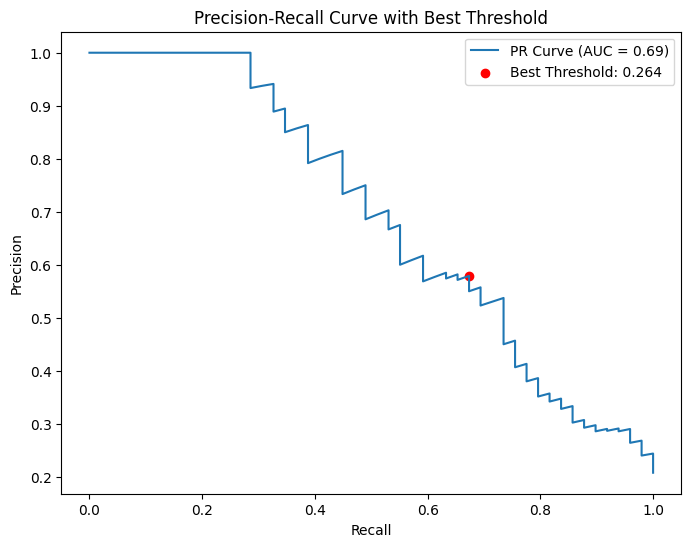

最佳阈值: 0.264
最终 F1 Score: 0.623
最终 AUC Score: 0.836


In [26]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import matplotlib.pyplot as plt

# 预测模型的概率得分
y_pred_stacking = stacking_model.predict_proba(X_test)[:, 1]

# 计算 Precision-Recall 曲线
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_stacking)

# 计算不同阈值下的 F1 分数
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # 避免除零错误

# 找到 F1 Score 最高的阈值
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

# 画出 Precision-Recall 曲线
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {auc(recall, precision):.2f})')
plt.scatter(recall[np.argmax(f1_scores)], precision[np.argmax(f1_scores)], color='red', label=f'Best Threshold: {best_threshold:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Best Threshold')
plt.legend()
plt.show()

# 使用最佳阈值进行预测
y_pred_adjusted = (y_pred_stacking >= best_threshold).astype(int)

# 计算最终的 F1 分数
final_f1 = f1_score(y_test, y_pred_adjusted)
final_auc = roc_auc_score(y_test, y_pred_stacking)

# 打印最佳阈值和最终的 F1 Score
print(f'最佳阈值: {best_threshold:.3f}')
print(f'最终 F1 Score: {final_f1:.3f}')
print(f'最终 AUC Score: {final_auc:.3f}')


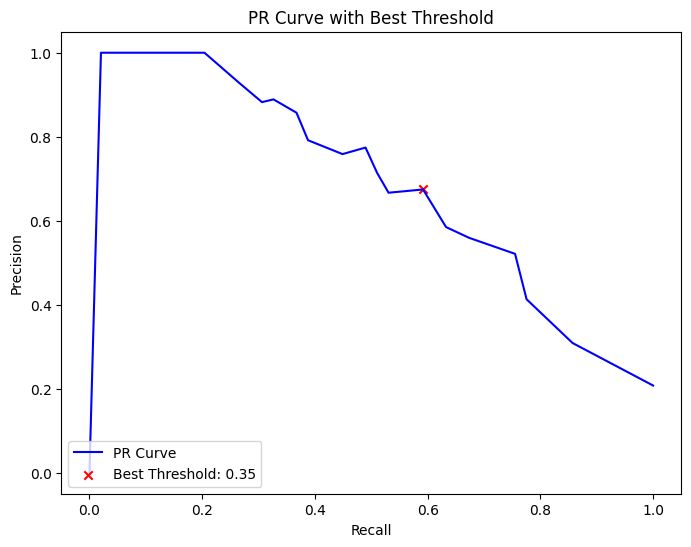

Best Threshold: 0.350
Maximum F1 Score: 0.6304
Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       187
           1       0.67      0.59      0.63        49

    accuracy                           0.86       236
   macro avg       0.79      0.76      0.77       236
weighted avg       0.85      0.86      0.85       236



In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, f1_score
# 获取预测的概率值
y_pred_proba = stacking_model.predict_proba(X_test)[:, 1]

# 设置不同的阈值范围
thresholds = np.arange(0.0, 1.05, 0.05)

# 初始化最佳阈值和最大F1
best_threshold = 0
max_f1 = 0

# 存储Precision, Recall, F1分数
precisions = []
recalls = []
f1_scores = []

# 遍历不同的阈值，计算每个阈值下的 Precision, Recall 和 F1 Score
for threshold in thresholds:
    y_pred = (y_pred_proba > threshold).astype(int)  # 根据阈值预测标签
    
    precision = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_pred == 1) if np.sum(y_pred == 1) > 0 else 0
    recall = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1)
    f1 = f1_score(y_test, y_pred)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    if f1 > max_f1:
        max_f1 = f1
        best_threshold = threshold

# 获取最大F1分数对应的索引
best_index = np.argmax(f1_scores)

# 绘制 PR 曲线
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label='PR Curve', color='blue')

# 标注最佳阈值点
plt.scatter(recalls[best_index], precisions[best_index], 
            color='red', marker='x', label=f'Best Threshold: {best_threshold:.2f}')

# 设置图例和标题
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve with Best Threshold')
plt.legend(loc='lower left')

# 显示图像
plt.show()

# 打印最佳阈值和F1
print(f"Best Threshold: {best_threshold:.3f}")
print(f"Maximum F1 Score: {max_f1:.4f}")

# 使用最佳阈值生成分类报告
y_pred_best_threshold = (y_pred_proba > best_threshold).astype(int)
report = classification_report(y_test, y_pred_best_threshold)
print("Classification Report at Best Threshold:")
print(report)